In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
from comet_ml import Experiment
import numpy as np
import scipy.spatial
import pandas as pd
import comet_ml
import sklearn.decomposition
import matplotlib.pyplot as plt
# import keras
from sklearn import preprocessing
from sklearn.decomposition import PCA
# %matplotlib inline
# Dimension reduction and clustering libraries
import umap
# import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import LeaveOneOut,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import pairwise_distances,mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from utils.readProfiles import readMergedProfiles
from utils.pred_models import *
from utils.saveAsNewSheetToExistingFile import saveAsNewSheetToExistingFile

# from utils import networksEvol, tsne, readProfiles
import umap

#### In this notebook we test how combinting two data modalities will improve preformance of the following tasks:
    1 - MOA prediction
    2 - ?

## MoA Prediction:
- Data Fusion Methods:
    - Early Fusion: simple concatenation
    - Late Fusion: desision probabilty average
    - SNF
    - CCA

## Datasets and MoA annotations:

#### LINCS
- Full Set:
    - 568 unique multi-label MoAs (163 of these labels have more than 1 moa label)
    
- Filt Set:
    - 284 unique multi-label MoAs (74 of these labels have more than 1 moa label)
    


#### CDRP-bio
- Full Set:
    - xx unique multi-label MoAs (74 of these labels have more than 1 moa label)
    
- Filt Set:
    - xx unique multi-label MoAs (163 of these labels have more than 1 moa label)
    
    
#### CDRP
- Full Set:
    - xx unique multi-label MoAs (74 of these labels have more than 1 moa label)
    
- Filt Set:
    - xx unique multi-label MoAs (163 of these labels have more than 1 moa label)
    


### Paths

In [3]:
procProf_dir='/home/ubuntu/datasetsbucket/Rosetta-GE-CP/'
# procProf_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/'
metadata_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/metadata/'
results_dir='./results/'

### Read GE and CP profiles 

In [59]:
################################################
# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS', 'CDRP-bio'
dataset='LINCS'


################################################
# CP Profile Type options: 'augmented' , 'normalized', 'normalized_variable_selected'
# 'normalized_feature_select_dmso'
profileType='normalized_feature_select_dmso'
profTypeAbbrev=''.join([s[0] for s in profileType.split('_')])

################################################
# filtering to compounds which have high replicates for both GE and CP datasets
highRepOverlapEnabled=1


################################################
pertColName='PERT'
profileLevel='treatment'; #'replicate'  or  'treatment'
if highRepOverlapEnabled:
    f='filt'
else:
    f=''

nRep=1
mergProf_repLevel,mergProf_treatLevel,cp_features,l1k_features=\
readMergedProfiles(procProf_dir,dataset,profileType,profileLevel,nRep,highRepOverlapEnabled);

moa_col='Metadata_MoA'

##################################
if dataset=='LINCS':
    mergProf_treatLevel[moa_col]=mergProf_treatLevel['Metadata_moa']
    mergProf_treatLevel.loc[mergProf_treatLevel['Metadata_moa'].isnull(),moa_col]=\
    mergProf_treatLevel.loc[mergProf_treatLevel['Metadata_moa'].isnull(),'moa'].str.lower()
    
    mergProf_treatLevel['Compounds']=mergProf_treatLevel['PERT'].str[0:13]


# mergProf_repLevel,mergProf_treatLevel,l1k_features,cp_features,pertColName=readMergedProfiles(dataset,profileType,nRep)
# cp_features,l1k_features=cp_features.tolist(),l1k_features.tolist()
# mergProf_repLevel['Compounds']=mergProf_repLevel['PERT'].str[0:13]

if profileLevel=='replicate':
    l1k=mergProf_repLevel[[pertColName]+l1k_features]
    cp=mergProf_repLevel[[pertColName]+cp_features]
elif profileLevel=='treatment':
    l1k=mergProf_treatLevel[[pertColName,'Compounds',moa_col]+l1k_features]
    cp=mergProf_treatLevel[[pertColName,'Compounds',moa_col]+cp_features]


scaler_ge = preprocessing.StandardScaler()
scaler_cp = preprocessing.StandardScaler()
l1k_scaled=l1k.copy()
l1k_scaled[l1k_features] = scaler_ge.fit_transform(l1k[l1k_features].values)
cp_scaled=cp.copy()
cp_scaled[cp_features] = scaler_cp.fit_transform(cp[cp_features].values.astype('float64'))


if 1:
    cp_scaled[cp_features] =preprocessing.MinMaxScaler(feature_range=(0, 1)).fit_transform(cp_scaled[cp_features].values)   
    l1k_scaled[l1k_features] =preprocessing.MinMaxScaler(feature_range=(0, 1)).fit_transform(l1k_scaled[l1k_features].values)           

    
merged_scaled=pd.concat([cp_scaled, l1k_scaled], axis=1)
merged_scaled = merged_scaled.loc[:,~merged_scaled.columns.duplicated()]    
merged_scaled['Compounds']=merged_scaled['PERT'].str[0:13]



#################### keep MOAs with more than "nSamplesMOA" compounds in their class

nSamplesMOA=1

nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Compounds']).sample(1).groupby([moa_col]).size().\
reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)


nSamplesforEachMOAclass2=mergProf_treatLevel.groupby([moa_col]).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)

listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>nSamplesMOA][moa_col].tolist()
le = preprocessing.LabelEncoder()
le.fit(listOfSelectedMoAs)

IDs4filteredMOAs=mergProf_treatLevel[mergProf_treatLevel[moa_col].isin(listOfSelectedMoAs)][pertColName].tolist()

filteredMOAs=merged_scaled[merged_scaled[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)
data4eval=[[cp_scaled[cp_scaled[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True),cp_features],\
           [l1k_scaled[l1k_scaled[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True),l1k_features],\
           [filteredMOAs,cp_features+l1k_features]]

filteredMOAs['Metadata_moa_num']=le.transform(filteredMOAs[moa_col].tolist())


/home/ubuntu/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (18,19,1249,1250) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


LINCS: Replicate Level Shapes (nSamples x nFeatures): cp:  52223 , 119 ,  l1k:  27837 , 978
l1k n of rep:  3.0
cp n of rep:  5.0
CP: from  9394  to  4647
l1k: from  8369  to  2338
CP and l1k high rep overlap:  1140
Treatment Level Shapes (nSamples x nFeatures+metadata): (1141, 122) (1141, 980) Merged Profiles Shape: (1141, 1101)


In [69]:
# len([u.split('|') for u in unq if '|' in u])

In [6]:
mergProf_treatLevel[moa_col]=mergProf_treatLevel['Metadata_moa']
mergProf_treatLevel.loc[mergProf_treatLevel['Metadata_moa'].isnull(),moa_col]=\
mergProf_treatLevel.loc[mergProf_treatLevel['Metadata_moa'].isnull(),'moa'].str.lower()
mergProf_treatLevel['Metadata_MoA'].unique().shape

(284,)

#### Number of Classes with more than one label

<IPython.core.display.Javascript object>


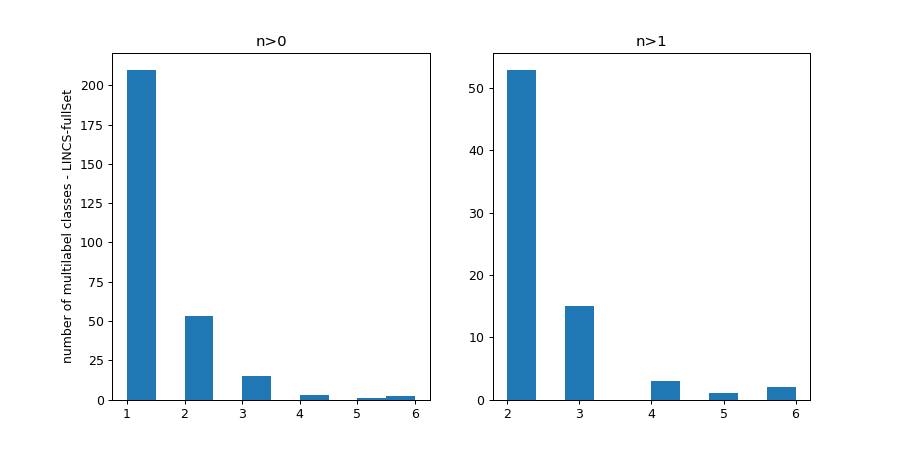

In [8]:
unq=mergProf_treatLevel['Metadata_MoA'].unique().tolist()
# n_multi_l=[len(u.split('|')) for u in unq if '|' in u]

fig, axes = plt.subplots(1,2,figsize=(10,5))

axes[0].hist([len(u.split('|')) for u in unq]);
axes[0].set_title('n>0');
axes[0].set_ylabel('number of multilabel classes - LINCS-fullSet');

axes[1].hist([len(u.split('|')) for u in unq if '|' in u]);
axes[1].set_title('n>1');#axes[1].set_ylabel('number of multilabel classes');

#### Number of Samples with more than one label

<IPython.core.display.Javascript object>


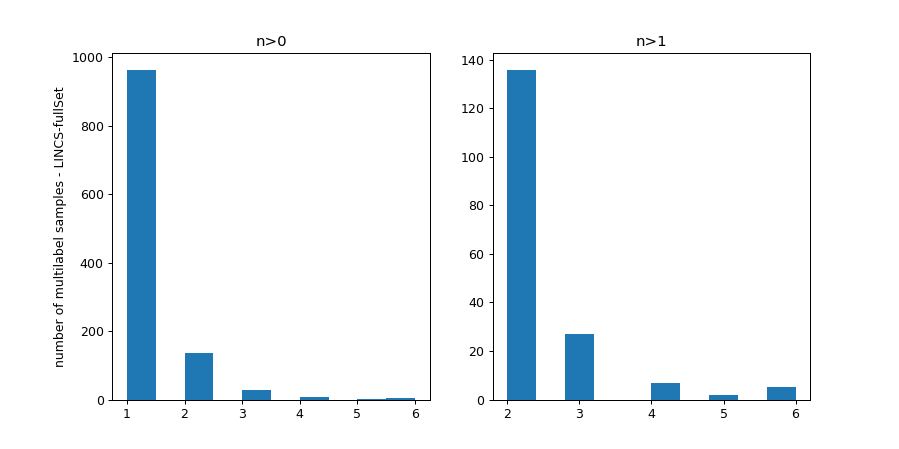

In [9]:
unq=mergProf_treatLevel['Metadata_MoA'].tolist()
# n_multi_l=[len(u.split('|')) for u in unq if '|' in u]

fig, axes = plt.subplots(1,2,figsize=(10,5))

axes[0].hist([len(u.split('|')) for u in unq]);
axes[0].set_title('n>0');axes[0].set_ylabel('number of multilabel samples - LINCS-fullSet');

axes[1].hist([len(u.split('|')) for u in unq if '|' in u]);
axes[1].set_title('n>1');#axes[1].set_ylabel('number of multilabel samples');

In [32]:


mergProf_treatLevel.columns[mergProf_treatLevel.columns.str.contains('moa')]
# list(set(mergProf_treatLevel.columns.tolist())-set(cp_features))

Index(['Metadata_moa', 'Metadata_alternative_moa', 'moa'], dtype='object')

In [75]:
mergProf_treatLevel[['Metadata_moa', 'Metadata_alternative_moa', 'moa',moa_col]]

,Metadata_moa,Metadata_alternative_moa,moa,Metadata_MoA
0,insulin sensitizer|PPAR receptor partial agonist,NaN,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist
1,insulin sensitizer|PPAR receptor partial agonist,NaN,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist
2,insulin sensitizer|PPAR receptor partial agonist,NaN,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist
3,insulin sensitizer|PPAR receptor partial agonist,NaN,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist
4,insulin sensitizer|PPAR receptor partial agonist,NaN,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist
...,...,...,...,...
6980,NaN,NaN,Potassium channel activator,potassium channel activator
6981,NaN,NaN,Potassium channel activator,potassium channel activator
6982,NaN,NaN,Potassium channel activator,potassium channel activator
6983,NaN,NaN,Potassium channel activator,potassium channel activator


In [31]:
mergProf_treatLevel[['Metadata_moa', 'Metadata_alternative_moa', 'moa',moa_col]]

,Metadata_moa,Metadata_alternative_moa,moa,Metadata_MoA
0,HSP inhibitor,NaN,HSP inhibitor,HSP inhibitor
1,HSP inhibitor,NaN,HSP inhibitor,HSP inhibitor
2,HSP inhibitor,NaN,HSP inhibitor,HSP inhibitor
3,HSP inhibitor,NaN,HSP inhibitor,HSP inhibitor
4,HSP inhibitor,NaN,HSP inhibitor,HSP inhibitor
...,...,...,...,...
1136,potassium channel activator,NaN,Potassium channel activator,potassium channel activator
1137,potassium channel activator,NaN,Potassium channel activator,potassium channel activator
1138,Abl kinase inhibitor|Bcr-Abl kinase inhibitor|...,NaN,Src inhibitor|Abl kinase inhibitor|Bcr-Abl kin...,Abl kinase inhibitor|Bcr-Abl kinase inhibitor|...
1139,NaN,NaN,Dopamine receptor antagonist,Dopamine receptor antagonist


In [21]:
mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isnull()]['moa']

134                  Rho associated kinase inhibitor
135                  Rho associated kinase inhibitor
136                  Rho associated kinase inhibitor
137                  Rho associated kinase inhibitor
147                                   MTOR inhibitor
148                                   MTOR inhibitor
149                                   MTOR inhibitor
150                                   MTOR inhibitor
151                                   MTOR inhibitor
170                  Glucocorticoid receptor agonist
171                  Glucocorticoid receptor agonist
172                  Glucocorticoid receptor agonist
173                  Glucocorticoid receptor agonist
174                  Glucocorticoid receptor agonist
228     Methylmalonyl CoA mutase stimulant|Vitamin B
252                        Potassium channel blocker
394                  Benzodiazepine receptor agonist
465                  Rho associated kinase inhibitor
466                  Rho associated kinase inh

In [63]:
# mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isnull()]['moa']

In [78]:
# mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isnull()].shape

(195, 1103)

In [40]:
# mergProf_treatLevel[mergProf_treatLevel['Metadata_MoA'].isnull()].shape

<ipython-input-7-427f03c47b5a>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cp['Compounds']=cp['PERT'].str[0:13]
<ipython-input-7-427f03c47b5a>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l1k['Compounds']=l1k['PERT'].str[0:13]


In [48]:
# cp['Compounds'],cp['PERT']
pd.merge(nSamplesforEachMOAclass,nSamplesforEachMOAclass2,how='inner',on=[moa_col])

,Metadata_MoA,size_x,size_y
0,adrenergic receptor antagonist,33,165
1,phosphodiesterase inhibitor,32,159
2,cyclooxygenase inhibitor,31,154
3,histamine receptor antagonist,24,120
4,acetylcholine receptor antagonist,21,105
...,...,...,...
563,apoptosis stimulant,1,5
564,antiviral|RNA synthesis inhibitor,1,5
565,antiviral,1,5
566,antitumor agent|ribonucleotide reductase inhib...,1,5


In [56]:
# pd.concat([nSamplesforEachMOAclass,nSamplesforEachMOAclass2])
nSamplesforEachMOAclass

,Metadata_MoA,size
0,adrenergic receptor antagonist,33
1,phosphodiesterase inhibitor,32
2,cyclooxygenase inhibitor,31
3,histamine receptor antagonist,24
4,acetylcholine receptor antagonist,21
...,...,...
563,apoptosis stimulant,1
564,antiviral|RNA synthesis inhibitor,1
565,antiviral,1
566,antitumor agent|ribonucleotide reductase inhib...,1


<ipython-input-10-683e67e481f8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nSamplesforEachMOAclass_['h']='n-compounds'
<ipython-input-10-683e67e481f8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nSamplesforEachMOAclass2_['h']='n-samples'


<IPython.core.display.Javascript object>


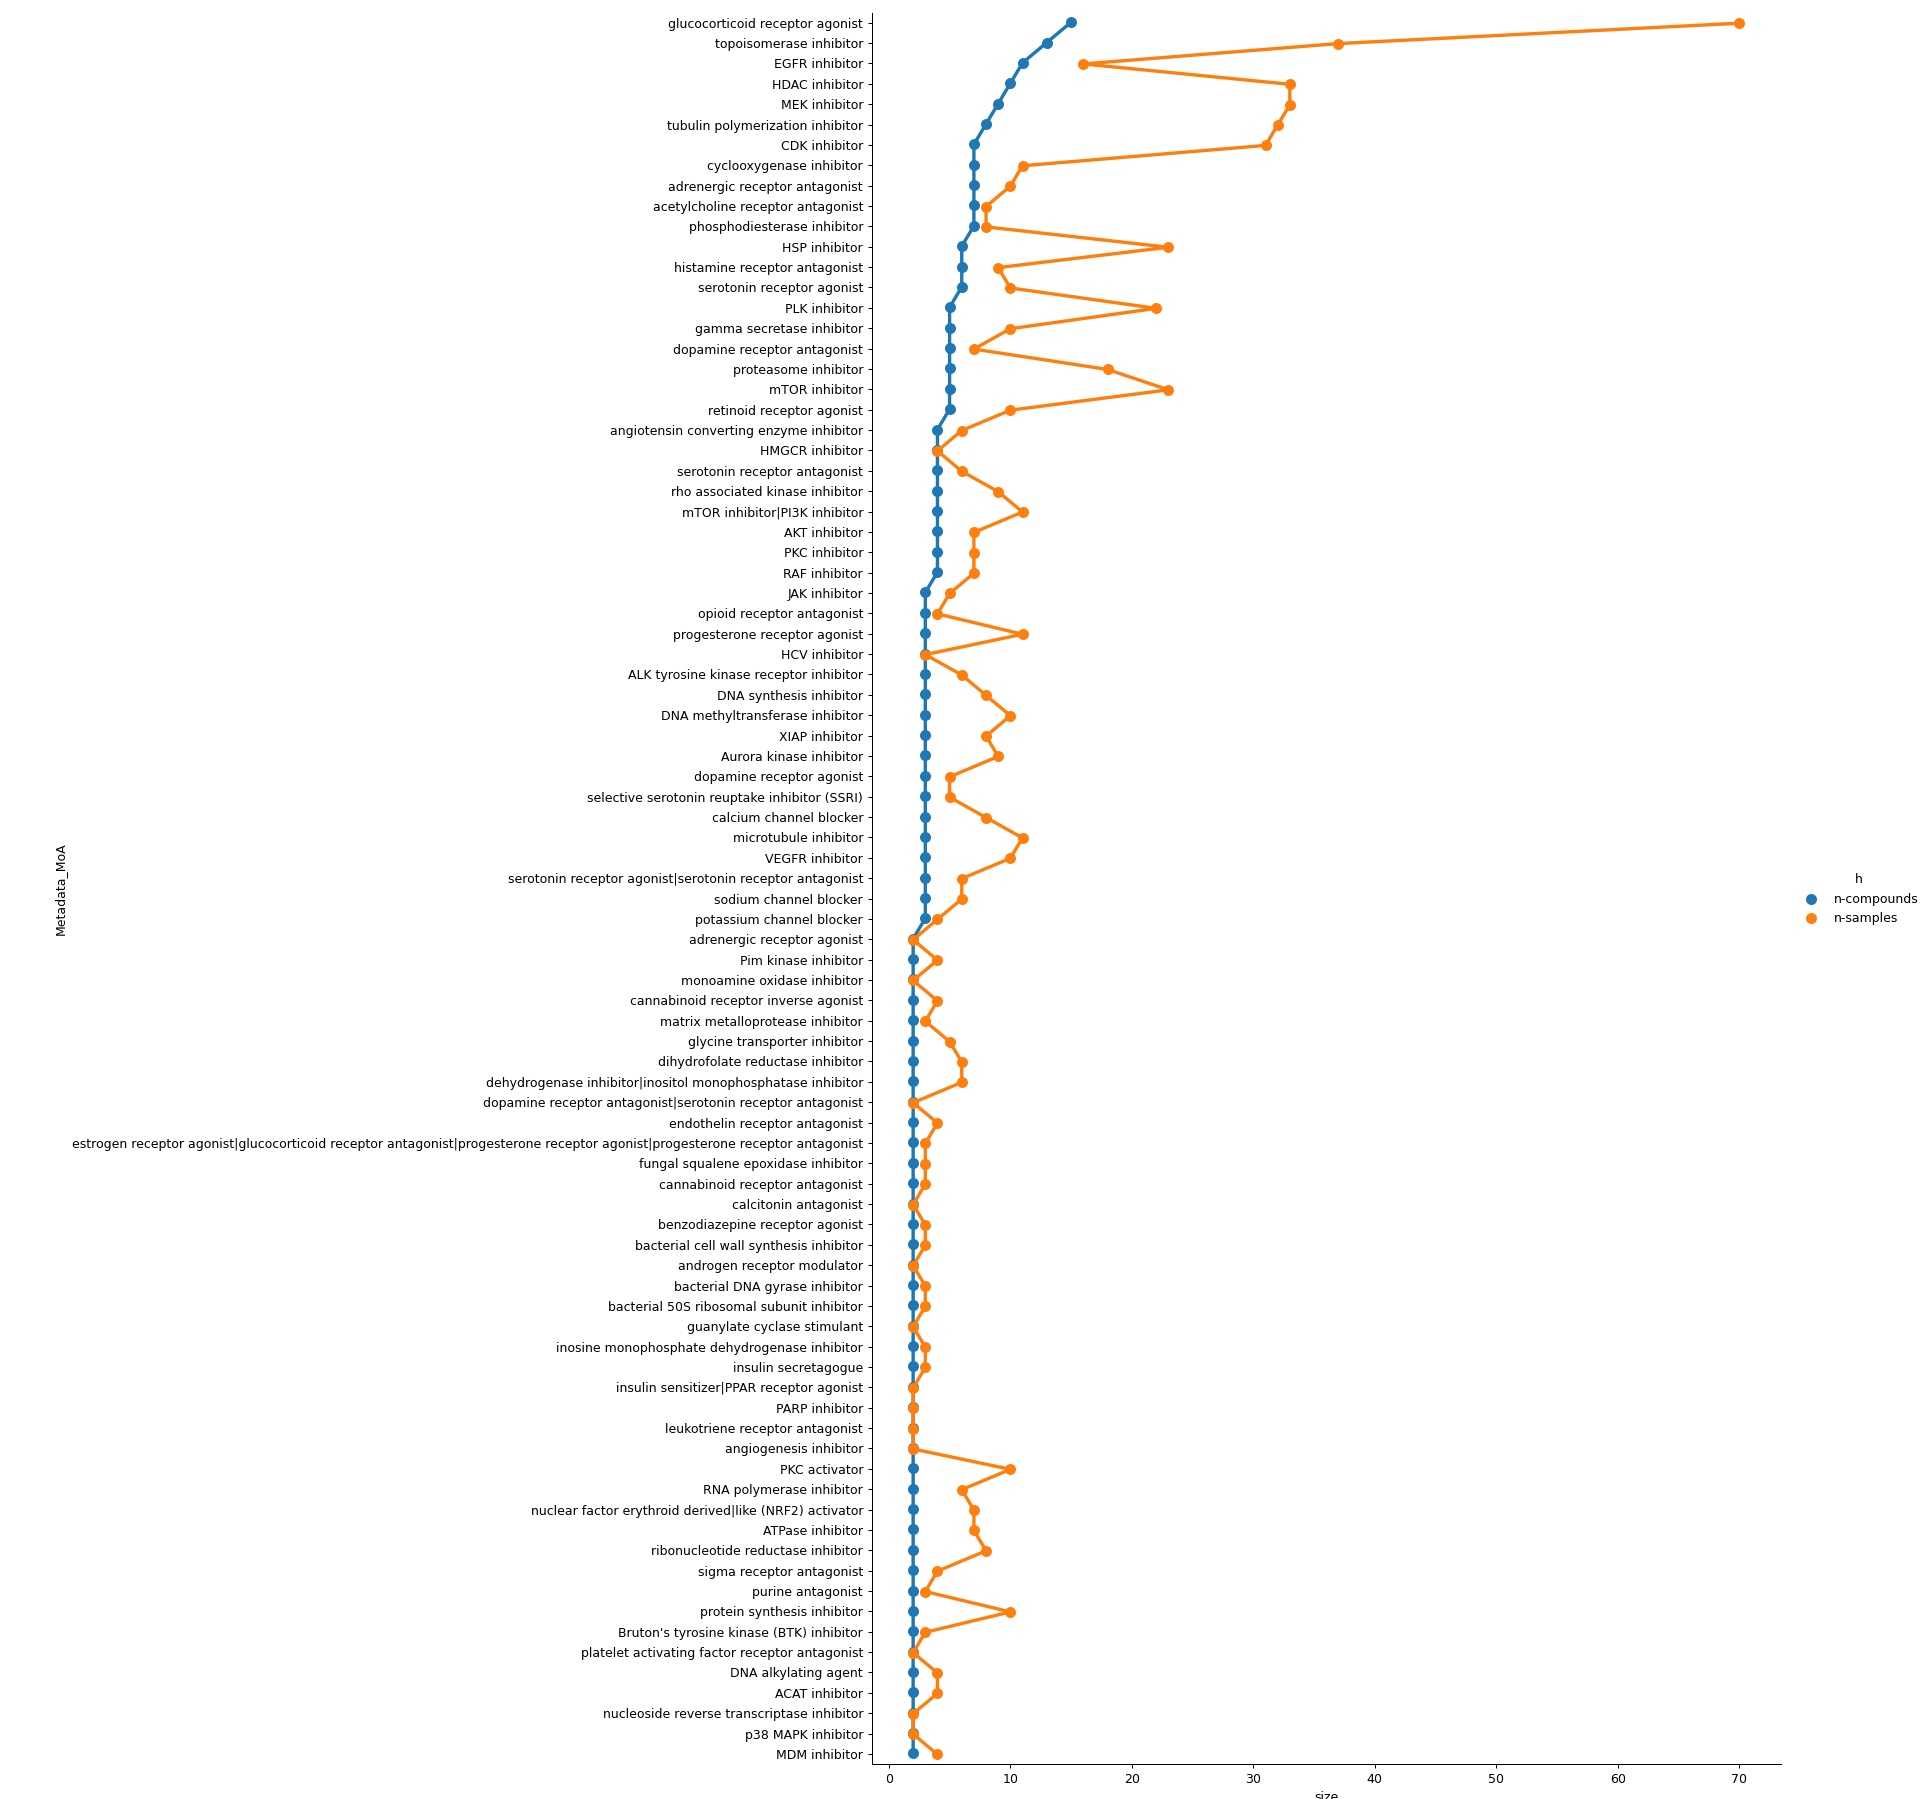

In [10]:
# plt.figure()
# fig, axes = plt.subplots(figsize=(20,5))
# nSamplesforEachMOAclass3=pd.merge(nSamplesforEachMOAclass,nSamplesforEachMOAclass2,how='inner',on=[moa_col])
nSamplesforEachMOAclass_=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>1]
nSamplesforEachMOAclass2_=nSamplesforEachMOAclass2[nSamplesforEachMOAclass2[moa_col].isin(nSamplesforEachMOAclass_[moa_col].tolist())]
nSamplesforEachMOAclass_['h']='n-compounds'
nSamplesforEachMOAclass2_['h']='n-samples'

nSamplesforEachMOAclass3=pd.concat([nSamplesforEachMOAclass_,nSamplesforEachMOAclass2_])

sns.catplot(x="size",y=moa_col, data=nSamplesforEachMOAclass3[nSamplesforEachMOAclass3['size']>1],\
            orient="h", height=20, aspect=1,hue='h',
                kind="point", dodge=True, cut=0, bw=.2)
# fig.tight_layout()

In [58]:
# repp_df
nSamplesforEachMOAclass2[meta_col]

NameError: name 'meta_col' is not defined

In [139]:
# mergProf_treatLevel.groupby(['moa']).size().reset_index().rename(columns={0:'nrep'}).sort_values(by='nrep')
moa_col='moa'

In [292]:
nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Metadata_moa']).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)
listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>1]['Metadata_moa'].tolist()
print(len(listOfSelectedMoAs))

191


In [225]:
# mergProf_treatLevel['Metadata_moa']=mergProf_treatLevel['Metadata_moa'].str.lower()
nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Metadata_moa']).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)
listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>1]['Metadata_moa'].tolist()
print(len(listOfSelectedMoAs))

14


In [226]:
listOfSelectedMoAs

['ATPase inhibitor',
 'tubulin polymerization inhibitor',
 'CDK inhibitor',
 'retinoid receptor agonist',
 'calcium channel blocker',
 'dopamine receptor antagonist',
 'protein synthesis inhibitor',
 'mitochondrial oxidative phosphorylation uncoupler',
 'HDAC inhibitor|cell cycle inhibitor',
 'HDAC inhibitor',
 'protein tyrosine kinase inhibitor|tyrosine kinase inhibitor',
 'EGFR inhibitor',
 'p38 MAPK inhibitor',
 'topoisomerase inhibitor']

In [46]:
nSamplesforEachMOAclass

,Metadata_MoA,size
0,adrenergic receptor antagonist,33
1,phosphodiesterase inhibitor,32
2,cyclooxygenase inhibitor,31
3,histamine receptor antagonist,24
4,acetylcholine receptor antagonist,21
...,...,...
563,apoptosis stimulant,1
564,antiviral|RNA synthesis inhibitor,1
565,antiviral,1
566,antitumor agent|ribonucleotide reductase inhib...,1


In [ ]:
# mergProf_treatLevel[mergProf_treatLevel['Compounds']=='BRD-K73323637'].Metadata_moa
# nSamplesforEachMOAclass2

nSamplesMOA=1
#############

##########
# mergProf_treatLevel['Metadata_moa']=mergProf_treatLevel['Metadata_moa'].str.lower()
# mergProf_treatLevel=mergProf_treatLevel[~mergProf_treatLevel[moa_col].isnull()].reset_index(drop=True)
# mergProf_treatLevel['Compounds']=mergProf_treatLevel['PERT'].str[0:13]

nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Compounds']).sample(1).groupby([moa_col]).size().\
reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)


nSamplesforEachMOAclass2=mergProf_treatLevel.groupby([moa_col]).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)
# lkjklj
listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>nSamplesMOA][moa_col].tolist()
le = preprocessing.LabelEncoder()
le.fit(listOfSelectedMoAs)

# corresPertID=[mergProf_treatLevel[mergProf_treatLevel['Metadata_moa']==i]['Metadata_pert_id'] for i in listOfSelectedMoAs]
# filteredMOAs=mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isin(listOfSelectedMoAs)].reset_index(drop=True)
IDs4filteredMOAs=mergProf_treatLevel[mergProf_treatLevel[moa_col].isin(listOfSelectedMoAs)][pertColName].tolist()


cp['Compounds']=cp['PERT'].str[0:13]
l1k['Compounds']=l1k['PERT'].str[0:13]
data4eval=[[cp,cp_features],[l1k,l1k_features],[merged_scaled,cp_features+l1k_features]]

In [58]:
IDs4filteredMOAs

['BRD-A03506276_0.04',
 'BRD-A03506276_0.12',
 'BRD-A03506276_0.37',
 'BRD-A03506276_1.11',
 'BRD-A03506276_3.33',
 'BRD-A05821830_0.04',
 'BRD-A05821830_0.12',
 'BRD-A05821830_0.37',
 'BRD-A05821830_1.11',
 'BRD-A05821830_3.33',
 'BRD-A07986123_3.33',
 'BRD-A09349126_0.04',
 'BRD-A09349126_0.12',
 'BRD-A09349126_0.37',
 'BRD-A09472452_1.11',
 'BRD-A10967948_0.04',
 'BRD-A10977446_3.33',
 'BRD-A11319535_0.04',
 'BRD-A11319535_0.12',
 'BRD-A11319535_0.37',
 'BRD-A11319535_1.11',
 'BRD-A11319535_3.33',
 'BRD-A12896037_0.12',
 'BRD-A12896037_1.11',
 'BRD-A13084692_3.33',
 'BRD-A13133631_0.04',
 'BRD-A13133631_0.12',
 'BRD-A13133631_0.37',
 'BRD-A13133631_1.11',
 'BRD-A13133631_3.33',
 'BRD-A13188892_0.12',
 'BRD-A13188892_3.33',
 'BRD-A14886633_0.04',
 'BRD-A14886633_0.37',
 'BRD-A14966924_0.37',
 'BRD-A14966924_1.11',
 'BRD-A14966924_3.33',
 'BRD-A15297126_0.04',
 'BRD-A15297126_0.12',
 'BRD-A15297126_0.37',
 'BRD-A15297126_1.11',
 'BRD-A15297126_3.33',
 'BRD-A15435692_0.04',
 'BRD-A1543

In [38]:
# nSamplesforEachMOAclass
# IDs4filteredMOAs
# pd.DataFrame(index=filteredMOAs['Compounds'].values,columns=['CP','GE','Early Fusion','Late Fusion'])
filteredMOAs.loc[test_index,'Compounds'].unique()[0]

'BRD-A03506276'

### MoA prediction using each dataset and early and late fusion of datasets

In [60]:
from sklearn.utils import class_weight
from sklearn.naive_bayes import GaussianNB,ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict, GroupKFold,LeaveOneGroupOut

# domXdata=merged_scaled.copy();
# domXfeats=data4eval[r][1]
# outdim_size=40

# filteredMOAs=domXdata[domXdata[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)
# filteredMOAs['Metadata_moa_num']=le.transform(filteredMOAs[moa_col].tolist())

moa_pred_res=pd.DataFrame(index=filteredMOAs['Compounds'].values,columns=['CP','GE','Early Fusion','Late Fusion'])

# n_of_random_sel=20
# n_of_random_sel=50
# n_folds=5
# acc_array_fullSet2_cdrp=np.zeros((n_of_random_sel,4));
# acc_array_filtSet2_cdrp=np.zeros((n_of_random_sel,4));
# for i in range(n_of_random_sel):

#     split_obj=GroupKFold(n_splits=k)
# #     split_obj = LeaveOneGroupOut()    
#     # Perform k-fold cross validation
#     scores = cross_val_score(clf, X, y, groups=group_labels,cv=split_obj,n_jobs=n_j)

# kf = KFold(n_splits=n_folds,random_state=1,shuffle=True)
# gkf=GroupKFold(n_splits=n_folds)

logo = LeaveOneGroupOut()

leG = preprocessing.LabelEncoder()
group_labels=leG.fit_transform(filteredMOAs['Compounds'].values)

i=0
# for train_index0, test_index in gkf.split(filteredMOAs, groups=group_labels):
for train_index, test_index in logo.split(filteredMOAs, groups=group_labels):
    print('rand ',i)
    
    
#     data_train = filteredMOAs.loc[train_index,domXfeats].values;
    labels_train=filteredMOAs.loc[train_index,'Metadata_moa_num'].tolist()
    print(filteredMOAs.loc[train_index,'Metadata_moa_num'].unique().shape)
    
#     data_test = filteredMOAs.loc[test_index,domXfeats].values;
    labels_test=filteredMOAs.loc[test_index,'Metadata_moa_num'].tolist()
    print(filteredMOAs.loc[test_index,'Metadata_moa_num'].unique().shape)    
    
    class_weightt = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(labels_train),y=labels_train)    
#         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")

    probs=[]
    for n,dt_modality,col in zip([0,1,2],data4eval,['CP','GE','Early Fusion']):
        
        data_m=dt_modality[0]   

        dt_train=data_m.loc[train_index,dt_modality[1]].values;
        dt_test=data_m.loc[test_index,dt_modality[1]].values; 
    #         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")
#         model_tr = GaussianNB()
#         model_tr = ComplementNB()

        model_tr = LogisticRegression(multi_class='multinomial',n_jobs=1,max_iter=1000,class_weight="balanced")
        model_tr.fit(dt_train,labels_train)
        
        accc=model_tr.score(dt_test,labels_test)
        
        moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]=accc*100
        probs.append(model_tr.predict_proba(dt_test))

#     labels_lateFusion=list(np.argmax((probs[0]+probs[1])/2,axis=1))
    labels_lateFusion=model_tr.classes_[np.argmax((probs[0]+probs[1])/2,axis=1)]
    moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],'Late Fusion']=\
    accuracy_score(labels_test,labels_lateFusion)*100

    
print(moa_pred_res.mean())


filename=results_dir+'/MoAprediction/pred_moa.xlsx'
saveAsNewSheetToExistingFile(filename,moa_pred_res,'fuseConcat-'+dataset+'-'+profTypeAbbrev+'-'+f)

# print('Accuracy: ',r, np.mean(Acc_list)*100)  

rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,)
(1,)
rand  0
(86,

In [33]:
le.inverse_transform(model_tr.predict(dt_test)),le.inverse_transform(labels_test)

(array(['microtubule inhibitor', 'microtubule inhibitor',
        'microtubule inhibitor', 'microtubule inhibitor',
        'microtubule inhibitor'], dtype='<U123'),
 array(['HSP inhibitor', 'HSP inhibitor', 'HSP inhibitor', 'HSP inhibitor',
        'HSP inhibitor'], dtype='<U123'))

In [61]:
# import sklearn as skl
# skl.__version__

In [63]:
# 
# _tr, filteredMOAs[cp_features[0:10]], filteredMOAs[moa_col].tolist(), groups=group_labels,cv=gkf)

In [62]:
# # scoring = {'recall0': make_scorer(recall_score, average = None}
# from sklearn.model_selection import cross_validate
# cross_validate(model_tr, filteredMOAs[cp_features[0:10]], filteredMOAs[moa_col].tolist(),\
#                 groups=group_labels,cv=gkf,scoring='balanced_accuracy', return_train_score = False)

In [64]:
# gkf=GroupKFold(n_splits=5)
# cross_val_score(model_tr, filteredMOAs[cp_features[0:10]], filteredMOAs[moa_col].tolist(),\
#                 groups=group_labels,cv=gkf,scoring='balanced_accuracy')

In [65]:
# cross_val_score(model_tr, filteredMOAs[cp_features[0:10]], filteredMOAs[moa_col].tolist(),\
#                 groups=group_labels,cv=gkf,scoring='f1_weighted')

In [85]:
# cross_val_score(model_tr, filteredMOAs[cp_features[0:10]], filteredMOAs[moa_col].tolist(),\
#                 groups=group_labels,cv=gkf,scoring='f1')

In [66]:
# cp.shape,l1k.shape,merged_scaled.shape
# merged_scaled['PERT']
# mergProf_treatLevel[moa_col].unique()
# mergProf_treatLevel
# IDs4filteredMOAs
# mergProf_treatLevel[mergProf_treatLevel[moa_col].isin(listOfSelectedMoAs)]['Compounds'].shape
# sorted(sklearn.metrics.SCORERS.keys())

In [67]:
len(listOfSelectedMoAs),len(IDs4filteredMOAs),mergProf_treatLevel.shape

(86, 752, (1141, 1103))

In [257]:
# merged_scaled['PERT']
# listOfSelectedMoAs
# cp_features
pertColName

'PERT'

In [246]:
# import os
# os.mkdir('../../results/dataIntegration')

In [228]:
len(listOfSelectedMoAs) #filt set (n>1) CDRP

14

In [296]:
len(listOfSelectedMoAs) #full set (n>1) cdrp

191

In [533]:
len(listOfSelectedMoAs) #full set (n>3)

84

In [547]:
len(listOfSelectedMoAs) #filt set(n>3)

24

In [96]:
len(listOfSelectedMoAs) #filt set (n>1)

72

In [366]:
len(listOfSelectedMoAs) #full set (n>1)

191

In [ ]:
len(listOfSelectedMoAs) #full set (n>1)

In [437]:
cp['Compounds']=cp['PERT'].str[0:13]
l1k['Compounds']=l1k['PERT'].str[0:13]

data4eval=[[cp,cp_features],[l1k,l1k_features],[merged_scaled,cp_features+l1k_features]]

In [245]:
ls ../../results/

checkpoint                 GeneVsCPfeature/
cpCategoriesHM-LINCS.png   modelW/
cpCategoriesHM.png         modelW.data-00000-of-00001
cpFeaturesGene_ccMat.csv   modelW.index
cpFeaturesGene_ccMat.eps   RepCor/
cpFeaturesGene_ccMat.pkl   results.csv
cpFeaturesGene_ccMat.png   results-nnC.csv
cpFeaturesGene_glmMat.csv  results-replicate-nnC.csv
cpFeaturesGene_glmMat.pkl  results-Treatment12120end.csv
cpFeaturesGene_glmMat.png  results-Treatment_1t0121.csv
cpFeaturesGene_miMat.csv   results-Treatment.csv
cpFeaturesGene_miMat.pkl   results-Treatment-lin-rand.csv
cpFeaturesGene_miMat.png   SingleCPfeatPred/
dataIntegration/           SingleGenePred/


In [247]:
# DataFuseResults
# pd.to_csv('../../results/dataIntegration/fusion_res.xlsx')
res_path='../../results/dataIntegration/fusion_res.xlsx'
saveAsNewSheetToExistingFile(res_path,DataFuseResults,'logisticReg')

In [363]:
saveAsNewSheetToExistingFile(res_path,DataFuseResults_loaded,'logisticReg')

[]


In [366]:
# DataFuseResults_loaded=pd.read_excel(res_path, sheet_name=None)['logisticReg']
# DataFuseResults_loaded

In [530]:
# acc_array_fullSet=np.copy(acc_array_filtSet)

In [235]:
# filteredMOAs.loc[test_index].groupby(['Metadata_moa']).sample(1).index.values

In [37]:
filteredMOAs['Metadata_moa'].unique().shape

(179,)

In [ ]:
Clustering performance

### MoA prediction using each CCA projected dataset and early and late fusion of CCA projected datasets 

In [70]:
from sklearn.cross_decomposition import CCA
from sklearn.utils import class_weight
from sklearn.naive_bayes import GaussianNB,ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict, GroupKFold,LeaveOneGroupOut


outdim_size=40

moa_pred_res_cca=pd.DataFrame(index=filteredMOAs['Compounds'].values,columns=['CP','GE','Early Fusion','Late Fusion'])

logo = LeaveOneGroupOut()

leG = preprocessing.LabelEncoder()
group_labels=leG.fit_transform(filteredMOAs['Compounds'].values)

i=0
# for train_index0, test_index in gkf.split(filteredMOAs, groups=group_labels):
for train_index, test_index in logo.split(filteredMOAs, groups=group_labels):
#     print('rand ',i)
    
#     data_train = filteredMOAs.loc[train_index,domXfeats].values;
    labels_train=filteredMOAs.loc[train_index,'Metadata_moa_num'].tolist()
    print(filteredMOAs.loc[train_index,'Metadata_moa_num'].unique().shape)
    
#     data_test = filteredMOAs.loc[test_index,domXfeats].values;
    labels_test=filteredMOAs.loc[test_index,'Metadata_moa_num'].tolist()
    print(filteredMOAs.loc[test_index,'Metadata_moa_num'].unique().shape)    
    
    class_weightt = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(labels_train),y=labels_train)    
#         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")
    data_train_l1k = filteredMOAs.loc[train_index,l1k_features].values;
    data_train_cp = filteredMOAs.loc[train_index,cp_features].values;
    
    cca = CCA(n_components=outdim_size)
    cca.fit(data_train_l1k, data_train_cp)
    X_c, Y_c = cca.transform(data_train_l1k, data_train_cp)    
    
    data_train=np.concatenate((X_c, Y_c), axis=1)
    
    data_test_l1k = filteredMOAs.loc[test_index,l1k_features].values;
    data_test_cp = filteredMOAs.loc[test_index,cp_features].values;    
    X_c_2, Y_c_2 = cca.transform(data_test_l1k, data_test_cp)    
    data_test=np.concatenate((X_c_2, Y_c_2), axis=1)
    

    probs=[]
    for col,dt_train,dt_test in zip(['CP','GE','Early Fusion'],[Y_c, X_c,data_train],[Y_c_2,X_c_2,data_test]):
#         print(n)
#         class_weightt = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(labels_train),y=labels_train)    
    
#         class_weightt = class_weight.compute_class_weight(class_weight='balanced',np.unique(labels_train),labels_train)    
    #         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")
#         model_tr=
        model_tr = LogisticRegression(multi_class='multinomial',n_jobs=3,max_iter=1000,class_weight="balanced")
        model_tr.fit(dt_train,labels_train)
        
        accc=model_tr.score(dt_test,labels_test)
        probs.append(model_tr.predict_proba(dt_test))
        moa_pred_res_cca.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]=accc*100

#     labels_lateFusion=list(np.argmax((probs[0]+probs[1])/2,axis=1))
    labels_lateFusion=model_tr.classes_[np.argmax((probs[0]+probs[1])/2,axis=1)]
#     acc_array_cca_filt2[i,n+1]=accuracy_score(labels_test,labels_lateFusion)*100        
    moa_pred_res_cca.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],'Late Fusion']=\
    accuracy_score(labels_test,labels_lateFusion)*100      
    

print(moa_pred_res_cca.mean())

filename=results_dir+'/MoAprediction/pred_moa.xlsx'
saveAsNewSheetToExistingFile(filename,moa_pred_res_cca,'fuseCCA-'+dataset+'-'+profTypeAbbrev+'-'+f)

# print('Accuracy: ',r, np.mean(Acc_list)*100)  

(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)
(86,)
(1,)

In [71]:
filename=results_dir+'/MoAprediction/pred_moa.xlsx'
saveAsNewSheetToExistingFile(filename,moa_pred_res_cca,'fuseCCA-'+dataset+'-'+profTypeAbbrev+'-'+f)

fuseCCA-LINCS-nfsd-filt  saved!


### MoA clustering using each dataset and SNF data fusion

In [73]:
from sklearn.cluster import spectral_clustering
from sklearn.metrics import v_measure_score, accuracy_score
from snf import compute
# logo = LeaveOneGroupOut()

# leG = preprocessing.LabelEncoder()
# group_labels=leG.fit_transform(filteredMOAs['Compounds'].values)


moa_pred_res_snf=pd.DataFrame(columns=['Data','Modality','NMI'])
# n_rand_moaClass=100
n_rand_moaClass=40
for i in range(20):
    print(i)
    listOfSelectedMoAs2=np.random.choice(merged_scaled[moa_col].unique(),n_rand_moaClass)
    IDs4filteredMOAs_2=merged_scaled[merged_scaled[moa_col].isin(listOfSelectedMoAs2)][pertColName].tolist()
    filteredMOAs_2=merged_scaled[merged_scaled[pertColName].isin(IDs4filteredMOAs_2)].reset_index(drop=True)
    snfInput=[filteredMOAs_2[cp_features].values,filteredMOAs_2[l1k_features].values]
    affinities = compute.make_affinity(snfInput, metric='euclidean')
    fused = compute.snf(affinities)
    
    labels=filteredMOAs_2[moa_col].tolist()

    le_2 = preprocessing.LabelEncoder()
    labels_categorical_2=filteredMOAs_2[moa_col].unique().tolist();
    le_2.fit(labels_categorical_2)
    labels_numerical_2=le_2.transform(labels)

    for m,d in zip(["CP","GE","fused(CP,GE)"],[affinities[0],affinities[1],fused]):
        pred_labels = spectral_clustering(d, n_clusters=n_rand_moaClass)
        nmi_snf=v_measure_score(np.random.permutation(pred_labels), labels)

        temp_df = pd.DataFrame(data={'NMI': [nmi_snf], 'Modality': [m]})
#         print(temp_df)
#         temp_df=pd.DataFrame(data=np.array([[nmi_snf],[m]]),columns=['NMI','Modality'])
#         ress_df_filt=ress_df_filt.append(temp_df)
        moa_pred_res_snf=moa_pred_res_snf.append(temp_df)
      


filename=results_dir+'/MoAprediction/pred_moa.xlsx'
saveAsNewSheetToExistingFile(filename,moa_pred_res_snf,'fuseSNF-'+dataset+'-'+profTypeAbbrev+'-'+f)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
fuseSNF-LINCS-nfsd-filt  saved!


In [398]:
# v_measure_score(np.random.permutation(labels), labels)
i

3

In [110]:
from sklearn.cluster import spectral_clustering
from sklearn.metrics import v_measure_score, accuracy_score

pred_labels = spectral_clustering(fused, n_clusters=557)
v_measure_score(pred_labels, labels)

In [241]:
n_unq_labels=np.unique(labels_numerical_2).shape[0]
pred_labels = spectral_clustering(affinities[0], n_clusters=n_unq_labels)
print('CP nmi: ',v_measure_score(pred_labels, labels))
pred_labels = spectral_clustering(affinities[1], n_clusters=n_unq_labels)
print('L1k nmi: ',v_measure_score(pred_labels, labels))

pred_labels = spectral_clustering(fused, n_clusters=n_unq_labels)
print('Fused nmi: ',v_measure_score(pred_labels, labels))

CP nmi:  0.4547027605050385
L1k nmi:  0.5047396813615548
Fused nmi:  0.638843132270044


In [240]:
n_unq_labels=np.unique(labels_numerical_2).shape[0]
pred_labels = spectral_clustering(compute.snf([affinities[0],affinities[0]]), n_clusters=n_unq_labels)
print('CP nmi: ',v_measure_score(pred_labels, labels))
pred_labels = spectral_clustering(compute.snf([affinities[1],affinities[1]]), n_clusters=n_unq_labels)
print('L1k nmi: ',v_measure_score(pred_labels, labels))

# pred_labels = spectral_clustering(fused, n_clusters=n_unq_labels)
# print('Fused nmi: ',v_measure_score(pred_labels, labels))

CP nmi:  0.6335442415981104
L1k nmi:  0.5446253167729914


In [79]:
v_measure_score(labels_numerical_2, pred_labels)

0.782523187741443

In [76]:
# len(indexes)
indexes[1].shape

(179,)

## Visualize the results

In [74]:
filename=results_dir+'/MoAprediction/pred_moa.xlsx'
saved_scores=pd.read_excel(filename, sheet_name=None)
saved_scores.keys()

dict_keys(['fuseConcat-LINCS-nfsd-filt', 'fuseCCA-LINCS-nfsd-filt', 'fuseSNF-LINCS-nfsd-filt'])

In [ ]:
# DataFuseResults=DataFuseResults_loaded.copy()
DataFuseResults=DataFuseResults.rename(columns={'acc':'Accuracy'})

fig, axes = plt.subplots(1,4,figsize=(10,5))
sns.set_context("paper")
sns.set_style("whitegrid")
# sns.rcParams['patch.force_edgecolor'] = True
# for d in range(5):#(len(datasets)):
sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples'],\
            palette="Set1",ax=axes[0])
axes[0].axhline(y=(1/557)*100,linestyle=':',color='r');
axes[0].set_ylim(0,20)
axes[0].set_title('(a)');

sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='Filtered Samples'],\
            palette="Set1",ax=axes[1])
axes[1].axhline(y=(1/179)*100,linestyle=':',color='r');
axes[1].set_ylim(0,70)
axes[1].set_title('(b)');

sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples - CCA'],\
            hue_order=['CP','GE','CP+GE'],palette="Set1",ax=axes[2])
axes[2].axhline(y=(1/557)*100,linestyle=':',color='r');
axes[2].set_ylim(0,20)
axes[2].set_title('(c)');

sns.boxplot(x="Data", y="NMI", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples - SNF'],\
            palette="Set1",ax=axes[3])
# axes[3].axhline(y=(1/557)*100,linestyle=':',color='r');
axes[3].set_ylim(10,100)
axes[3].set_title('(d)');
fig.tight_layout()

In [ ]:
import matplotlib.style as style
style.use('seaborn-colorblind')
DataFuseResults=DataFuseResults.rename(columns={'acc':'Accuracy'})

hfont = {'fontname':'sans-serif'}

# plt.title('title',**csfont)

fig, axes = plt.subplots(1,3,figsize=(9,6))
fig.suptitle('MoA Classification', fontsize=15,**hfont)

sns.set_context("paper")
sns.set_style("whitegrid")
# sns.rcParams['patch.force_edgecolor'] = True
# for d in range(5):#(len(datasets)):
sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples'],\
            ax=axes[0])
axes[0].axhline(y=(1/557)*100,linestyle=':',color='r');
axes[0].set_ylim(0,30)
axes[0].set_title('(a)');

sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='Filtered Samples'],\
            ax=axes[2])
axes[2].axhline(y=(1/179)*100,linestyle=':',color='r');
axes[2].set_ylim(0,100)
axes[2].set_title('(c)');
axes[2].set(ylabel=None)

sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples - CCA'],\
            ax=axes[1])
# hue_order=['CP','GE','CP+GE']
axes[1].axhline(y=(1/557)*100,linestyle=':',color='r');
axes[1].set_ylim(0,30)
axes[1].set_title('(b)');
axes[1].set(ylabel=None)

# sns.boxplot(x="Data", y="NMI", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples - SNF'],\
#             palette="cividis",ax=axes[3])
# # axes[3].axhline(y=(1/557)*100,linestyle=':',color='r');
# axes[3].set_ylim(0,100)
# axes[3].set_title('(d)');
# fig.tight_layout()
fig.savefig('moa_clussif.eps')

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(2.5,6))
fig.suptitle('MoA Clustering', fontsize=15,**hfont)

sns.boxplot(x="Data", y="NMI", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples - SNF'],\
            palette="cividis",ax=axes)
# axes[3].axhline(y=(1/557)*100,linestyle=':',color='r');
axes.set_ylim(0,100)
axes.set_title('(d)');
# fig.tight_layout()
fig.savefig('moa_clustering.eps',bbox_inches='tight')